# Movie Review Sentiment Analysis

## 1. Import Modules

In [1]:
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# package used to creat wordclouds
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
# Scikit-learn is a free software machine learning library for the Python programming language.

# Some classes help us to deal with data
from sklearn.feature_extraction.text import TfidfVectorizer

# Some classes help us to implement ML methods and evaluate models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

In [4]:
# Keras is a high-level neural networks API

# Some classes help us to deal with data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

C:\Users\sheng\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
# Some classes help us to bulid neural networks
from keras.models import Sequential
from keras.layers import Embedding, LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping

## 2. [Loading Data: Rotten Tomatoes Movie Review Dataset](https://www.kaggle.com/c/movie-review-sentiment-analysis-kernels-only/data)
- The dataset was download from Kaggle, we can click on the hyperlink to see the detailed description.
- The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset.
- Each Sentence has been parsed into many phrases and sentiment labels are associated with not only the whole sentences but also phrases.
- The sentiment labels are:
    - 0 - negative
    - 1 - somewhat negative
    - 2 - neutral
    - 3 - somewhat positive
    - 4 - positive

In [6]:
# Loading the dataset
data_phrase = pd.read_csv('./data.tsv', sep='\t', header='infer', index_col='PhraseId')

In [7]:
# Let's explore the structure of this dataset

# Each phrase has a PhraseId. Each sentence has a SentenceId.
# Sentiment labels are associated with not only the whole sentences but also phrases
# The sentence with SentenceId = 8543 is "The movie 's downfall is to substitute plot for personality ."

data_phrase.iloc[156031:156040,:]

,SentenceId,Phrase,Sentiment
PhraseId,,,
156032,8543,The movie 's downfall is to substitute plot fo...,1
156033,8543,The movie 's downfall,1
156034,8543,is to substitute plot for personality .,1
156035,8543,is to substitute plot for personality,1
156036,8543,to substitute plot for personality,2
156037,8543,substitute plot for personality,1
156038,8543,substitute plot,2
156039,8543,for personality,2
156040,8544,"The film is darkly atmospheric , with Herrmann...",2


In [8]:
# Extra the all the sentences from the dataset
data_sentence = data_phrase.groupby('SentenceId').first()

# Rename the dataset
data_sentence = data_sentence.rename(index=str, columns={'Phrase': 'Sentence'})
data_sentence.head()

,Sentence,Sentiment
SentenceId,,
1,A series of escapades demonstrating the adage ...,1
2,"This quiet , introspective and entertaining in...",4
3,"Even fans of Ismail Merchant 's work , I suspe...",1
4,A positively thrilling combination of ethnogra...,3
5,Aggressive self-glorification and a manipulati...,1


## 3. Exploratory Data Analysis 

In [9]:
# Let's first see the distribution of the "Sentiment"
data_phrase.groupby('Sentiment').count().Phrase

Sentiment
0     7072
1    27273
2    79582
3    32927
4     9206
Name: Phrase, dtype: int64

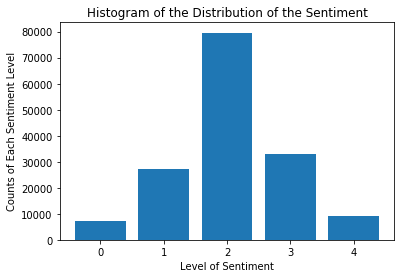

In [10]:
# Plot above counts
# It is very clear that most of phrases are labeled with 2, i.e. neutral
sentiment_labels = np.array([0,1,2,3,4])
sentiment_counts = data_phrase.groupby('Sentiment').count().Phrase
plt.bar(sentiment_labels, sentiment_counts, align='center')
plt.gca().set_xticks(sentiment_labels)
plt.title('Histogram of the Distribution of the Sentiment')
plt.xlabel('Level of Sentiment')
plt.ylabel('Counts of Each Sentiment Level')
plt.show()

In [11]:
# Now, let's get some intuition about the sentences labelled as "neutral" 
data_sentence.query('Sentiment== 2').head()

,Sentence,Sentiment
SentenceId,,
18,Like a less dizzily gorgeous companion to Mr. ...,2
20,It 's everything you 'd expect -- but nothing ...,2
24,That the Chuck Norris `` grenade gag '' occurs...,2
25,The plot is romantic comedy boilerplate from s...,2
26,"It arrives with an impeccable pedigree , mongr...",2


In [12]:
# Create a list contains all of the sentences labelled as "neutral"
# Here we care more about the sentences rather than phrases as there are lots of phrases repeated
text_2 = " ".join(review for review in data_sentence.query('Sentiment== 2').Sentence)
# Create a WordCloud object
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text_2)

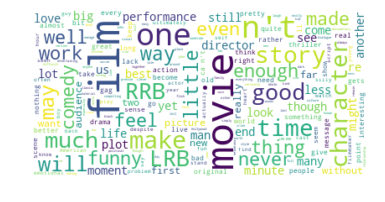

In [13]:
# Plot the wordcloud of those reviews with neutral sentiment
# We will discuss later that this word cloud indicates something BAD for us
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [14]:
# Now, let's explore the most common words in those sentences labelled with 0 and 4 i.e. "negative" and "positive"
# Here, we define a function to create histogram in order to avoid some repetition codes

# Set the stopwords
stopwords = set(STOPWORDS)
stopwords.update(['movie','film','character','characters','story','one','make','will','is'])

def barplot(sentiment_level=2):
    
    sentence = data_sentence.groupby('Sentiment').get_group(sentiment_level)
    text = " ".join(s for s in sentence.Sentence)
    
    wordcloud = WordCloud(stopwords=stopwords, max_words=15).generate(text)
    
    labels = list(wordcloud.words_.keys())
    values = list(wordcloud.words_.values())

    plt.bar(labels, values, align='center', alpha=0.9)
    plt.xticks(labels, rotation='vertical')
    plt.show()

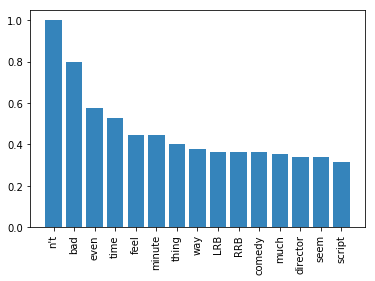

In [15]:
# First 15 common words within sentence labelled with 0, i.e. negative
# We can see some nagative words such as "bad", "n't"
# However, words like "n't" is also common in sentence labelled with 2
barplot(0)

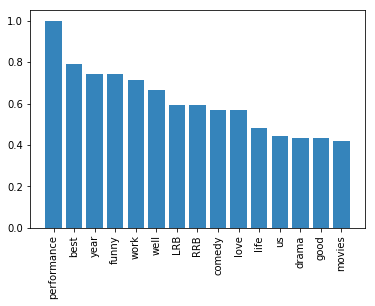

In [16]:
# First 15 common words within sentence labelled with 4, i.e. positive
# We can see some positive words such as "best", "love", "good"
# However, words like "good" is also common in sentence labelled with 2
barplot(4)

In [17]:
# We will see how single word is can mislead us
# We can see that the following sentece with 2 "good", but the sentiment is 1 (somewhat negative)!! 
# This is because some words like "but", "however" can change the direction of semtiment totally!!
data_phrase.iloc[0,1]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

## 4. Random Forest
- Random Forest is a very handy and easy to use algorithm to do classification.
- Random Forest classifier can handle overfitting problem.

- **After runing this algorithm, you will find random forest is not suitable for movie review sentiment analysis.**
- **This is because random forest use single words as features and cannot capture the meaning of longer phrases properly.**

In [18]:
# Split the data into training and testing sets.
xs_train, xs_test, ys_train, ys_test = train_test_split(data_sentence.Sentence, data_sentence.Sentiment, test_size=0.25)

In [19]:
# Create a TfidfVectorizer objects that help us to convert a collection of raw documents to a matrix of TF-IDF features
Tfidf = TfidfVectorizer()
# Learn vocabulary and idf from the training set and transform xs_train and xs_test 
xstfidf_train = Tfidf.fit_transform(xs_train)
xstfidf_test = Tfidf.transform(xs_test)

In [20]:
# Create a Random Forest Classifier
# We can use Grid Search to choose a suitable hyperparameters such as "n_estimators", "max_depth"
RandomForest = RandomForestClassifier(n_jobs=-1, max_features='auto', n_estimators=200, max_depth=15)

In [21]:
# Train this Classifier
RandomForest.fit(xstfidf_train, ys_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [22]:
# Use Grid Search to find a suitable parameters
# It takes several seconds but you don't have to run this
param={"n_estimators":[200, 300],"max_depth":[5, 10, 15]}
gridsearch = GridSearchCV(RandomForest, param_grid=param, cv=3)
gridsearch.fit(xstfidf_test, ys_test)

# The best parameters in param (candidates defined above)
gridsearch.best_params_

{'max_depth': 10, 'n_estimators': 200}

In [23]:
# Let's do cross validation on this random forest algorithms 
cross_val_score(RandomForest, Tfidf.transform(data_sentence.Sentence), data_sentence.Sentiment, cv=5)

array([0.33138173, 0.34642438, 0.32727273, 0.32785924, 0.33489736])

In [24]:
# Let's see the accuracy of this algorithm!
# The accuracy is very low!!
# This is not surprise as random forest cannot capture the meaning of long phrases properly.
RandomForest.score(xstfidf_test, ys_test)

0.323019221753399

## 5. Recurrent Neural Network Model
- [RNNs](https://en.wikipedia.org/wiki/Recurrent_neural_network) can use their internal state (memory) to process sequences of inputs and thus applicable to tasks speech recognition and here sentiment classification.
- A Recurrent Neural Network(RNN) composed of LSTM units is often called an LSTM network.
- A basic Long short-term memory (LSTM) units often plot like following:(the picture is from: https://developer.nvidia.com/discover/lstm)
<img src="images/LSTM.png" style="width:400px;height:200px;"> <br>
<caption><center> **Figure 1**: A basic Long short-term memory (LSTM) units. </center></caption>

- LSTM network is capable of learning long-term dependencies. For example, one sentence starts with "The director of this moive is very famous, ". But whether or not this sentence is positive or negative depends on the following. For example, "The director of this moive is very famous, but his/her movie this time is disappointing." or "The director of this moive is very famous, I think this moive will help his/her to get Oscars."

In [25]:
# Get list of all the phrase we have and lower all of them
phrase = data_phrase.Phrase.str.lower()
# Get the length of the longest phrase
maxlen = len(max(phrase, key=len).split())

### 5.1 Word Embedding
- Here we will use [Global Vectors](https://nlp.stanford.edu/projects/glove/) for Word Representation
- We will use pre-trained embedding matrix ["glove.6B.50d.txt"](https://www.kaggle.com/watts2/glove6b50dtxt) to accelerate our algorithms
- Actually, we can use more complex pre-trained embedding matrix such as "glove.6B.300d" to do this, and the accuracy will increase. However, it is to big to upload I guess.

In [26]:
# dictionary contains all the vector representations of words in GloVe word vectors
word_to_vec_map = {}

with open('./glove.6B.50d.txt', 'r', encoding='utf8') as f:
    word = set()
    for line in f:
        line = line.strip().split()
        curr_word = line[0]
        word.add(curr_word)
        word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)

In [27]:
# Define a Text tokenization utility class
tokenizer = Tokenizer()
tokenizer.fit_on_texts(word_to_vec_map.keys())

# dictionary mapping from words to their indices
word_to_index = tokenizer.word_index

In [28]:
# Preprocessing on the Feature/Phrase Data
X_tokenized = tokenizer.texts_to_sequences(phrase)
X = pad_sequences(X_tokenized, maxlen=maxlen)

In [29]:
# Preprocessing on the Target/Sentiment Data

# extract the target (y) from the train_data_raw
y = np.array(data_phrase.Sentiment)
# change the y_train into One-Hot representation
Y = to_categorical(y)

### 5.2 Create the embedding matrix

In [30]:
# Size of vocabulary
voc_len = len(word_to_index) + 1    
# dimensionality of the GloVe word vectors
emb_dim = word_to_vec_map["a"].shape[0]

In [31]:
embedding_matrix = np.zeros((voc_len,emb_dim))

# Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
for word, index in word_to_index.items():
    if word_to_vec_map.get(word) is not None:
        embedding_matrix[index, :] = word_to_vec_map[word]

### 5.3 Build the RNN model based on Keras

In [32]:
# Define Keras embedding layer with the correct output/input sizes, make it trainable.
embedding_layer = Embedding(voc_len, 
                            emb_dim, 
                            input_length=maxlen, 
                            trainable=True, 
                            weights=[embedding_matrix],
                            mask_zero=True)

model = Sequential()
# Propagate the model from embedding_layer
model.add(embedding_layer)
# Propagate the embeddings through an LSTM layer
model.add(LSTM(emb_dim, activation='relu', return_sequences=True))
# Add dropout with a probability of 0.2
model.add(Dropout(0.2))
# Propagate the embeddings through an LSTM layer
model.add(LSTM(emb_dim, activation='relu'))
# Add dropout with a probability of 0.2
model.add(Dropout(0.2))
# Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
model.add(Dense(5, activation='softmax'))

In [33]:
# Summary of this RNN/LSTM model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 51, 50)            16962600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 51, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 51, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 255       
Total params: 17,003,255
Trainable params: 17,003,255
Non-trainable params: 0
________________________________________________________________

### 5.4 Compile and Fit the RNN/LSTM

In [34]:
# Stop training when a monitored quantity has stopped improving
callbacks = [EarlyStopping(monitor='val_loss', patience=1)]

In [35]:
# Compile our Model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [36]:
# Fit and estimate our Model
model.fit(X, Y, epochs=10, batch_size=144, validation_split=0.2, callbacks=callbacks)

Train on 124848 samples, validate on 31212 samples
Epoch 1/10
124848/124848 [==============================] - 327s 3ms/step - loss: 1.0255 - acc: 0.5900 - val_loss: 0.9560 - val_acc: 0.6027
Epoch 2/10
124848/124848 [==============================] - 373s 3ms/step - loss: 0.8323 - acc: 0.6551 - val_loss: 0.9433 - val_acc: 0.6119
Epoch 3/10
124848/124848 [==============================] - 344s 3ms/step - loss: 0.7716 - acc: 0.6798 - val_loss: 0.9559 - val_acc: 0.6106


### 5.5 Conclusion and Comparison
- The accuarcy is 61% which is very high compared with Random Forest
- The accuarcy can be improved by using bigger embedding matrix or more complex network or LSTM units like Bi-LSTM
- The RNN/LSTM does improve the ability to capture the meaning of longer phrases

In [37]:
model.save_weights("Trained_model.model")